In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pi
import plotly.express as px

from scipy import stats
%matplotlib inline


import xgboost as xgb

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
df = pd.read_csv('./data.csv',  parse_dates=['date'], index_col='date')

In [3]:
df.head()

,price
date,
2008-01-15,5331.605
2008-02-15,5787.000
2008-03-15,6549.875
2008-04-15,7222.500
2008-05-15,8588.890


In [4]:
print('Total num of missing values:') 
print(df.price.isna().sum())
df.price.isna()

Total num of missing values:
0


date
2008-01-15    False
2008-02-15    False
2008-03-15    False
2008-04-15    False
2008-05-15    False
              ...  
2023-05-15    False
2023-06-15    False
2023-07-15    False
2023-08-15    False
2023-09-15    False
Name: price, Length: 189, dtype: bool

In [5]:
dataset = df.copy()
dataset = dataset.resample('W').ffill()
# Split train data and test data
train_size = int(len(dataset)*0.8)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = dataset.iloc[:train_size]
test_data = dataset.iloc[train_size:]

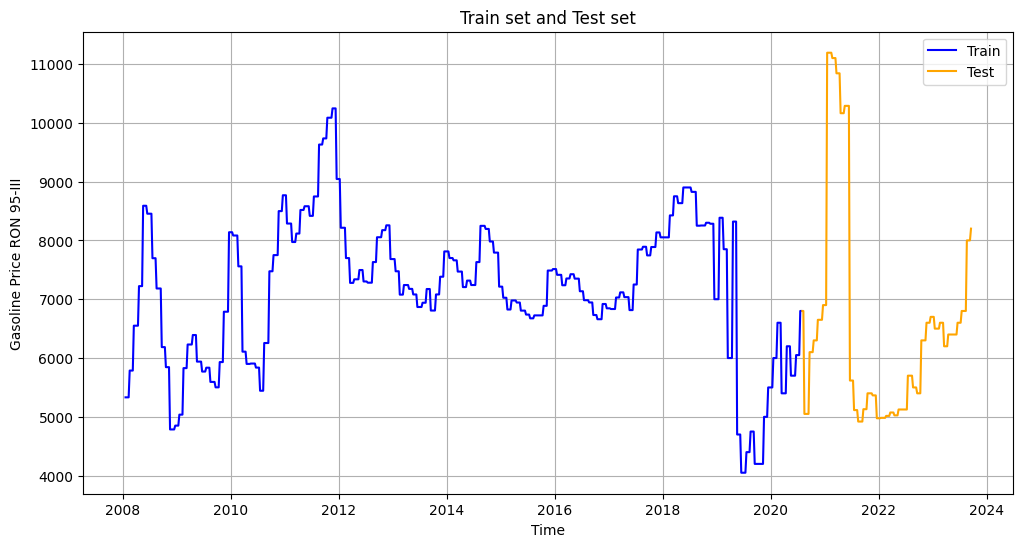

In [6]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE cho tập train và test
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth cho tập train
plt.plot(train_data['price'], label='Train', color='blue')

# Vẽ đường ground truth cho tập test
plt.plot(test_data['price'], label='Test', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Train set and Test set')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


In [7]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [8]:
print('Training data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Training data shape:  (654, 1)
Test data shape:  (164, 1)


In [9]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.squeeze(np.array(Xs), axis=-1), np.array(ys),
# Gia 12 thang
look_back = 48
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (606, 48)
y_train.shape:  (606, 1)
X_test.shape:  (116, 48)
y_test.shape:  (116, 1)


In [10]:
y_train[0]

array([0.12929245])

In [11]:
X_train_xgb, y_train_xgb = X_train, y_train
X_test_xgb, y_test_xgb = X_test, y_test

In [12]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             max_depth=4, 
                             learning_rate=0.1, 
                             n_estimators=40, 
                            )
model_xgb.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=40, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
y_train_pred_xgb = model_xgb.predict(X_train_xgb)
y_train_pred_xgb = scaler.inverse_transform(y_train_pred_xgb.reshape(-1, 1))
y_train_xgb = scaler.inverse_transform(y_train_xgb)

In [14]:
model_xgb.save_model("model_xgb.keras")


In [15]:
rmse_train_xgb = np.sqrt(mean_squared_error(y_train_xgb, y_train_pred_xgb))
r2_train_xgb = r2_score(y_train_xgb, y_train_pred_xgb)

print("RMSE (XGB): ", rmse_train_xgb)
print("R-squared (XGB): ", r2_train_xgb)

RMSE (XGB):  143.15782043126515
R-squared (XGB):  0.9850606960732535


In [16]:
y_test_pred_xgb = model_xgb.predict(X_test_xgb)
y_test_pred_xgb = scaler.inverse_transform(y_test_pred_xgb.reshape(-1, 1))
y_test_xgb = scaler.inverse_transform(y_test_xgb)

In [17]:
# Evaluate the model
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_test_pred_xgb))
r2_test_xgb = r2_score(y_test_xgb, y_test_pred_xgb)

print("RMSE (XGB): ", rmse_test_xgb)
print("R-squared (XGB): ", r2_test_xgb)

RMSE (XGB):  315.9981210833594
R-squared (XGB):  0.8473974148584027


In [18]:
days = 12
df_gasolinePrices_pre = df.copy()
gasolinePrices_scaled = scaler.transform(df_gasolinePrices_pre)

# Lấy dữ liệu cuối cùng từ tập dữ liệu
last_data = gasolinePrices_scaled[-49:]
last_data = last_data.reshape(1, -1)[:, -(49-1):]

predicted_prices_xgb = []
for day in range(days):
    next_prediction = model_xgb.predict(last_data)
    last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
    predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
    predicted_prices_xgb.append(predicted_price[0, 0])
    
last_date = df_gasolinePrices_pre.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=days, freq='D')

predicted_df_xgb = pd.DataFrame(index=future_dates, columns=['price'])

for day, price in enumerate(predicted_prices_xgb, start=1):
    predicted_df_xgb.loc[last_date + pd.DateOffset(days=day)] = price

df_gasolinePrices_pre = pd.concat([df_gasolinePrices_pre, predicted_df_xgb], axis=0)

In [19]:
import pandas as pd

last_date = '11/25/2023'
future_dates = pd.date_range(start=last_date , periods=4, freq='W')
future_dates

DatetimeIndex(['2023-11-26', '2023-12-03', '2023-12-10', '2023-12-17'], dtype='datetime64[ns]', freq='W-SUN')

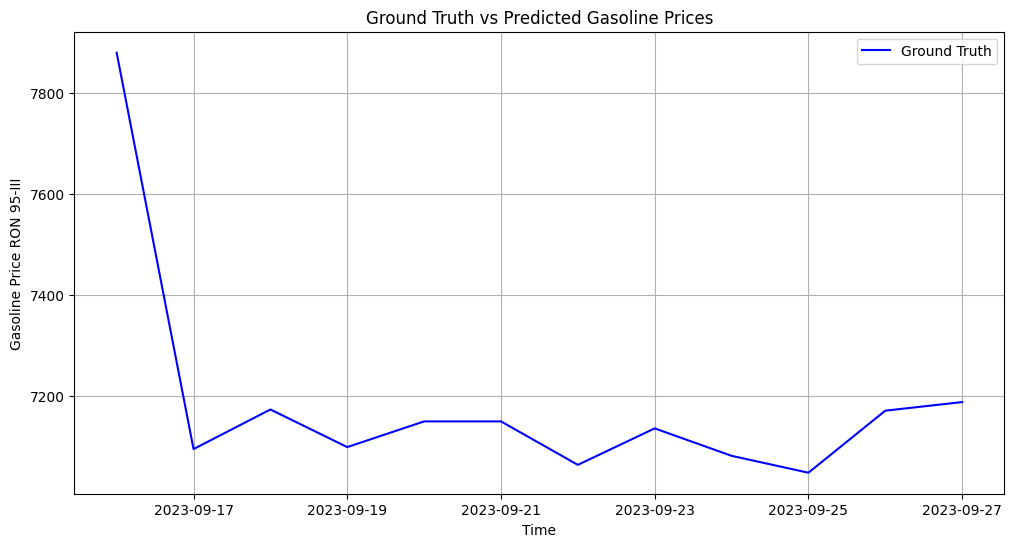

In [20]:
plt.figure(figsize=(12, 6))

plt.plot(predicted_df_xgb.index, predicted_df_xgb['price'], label='Ground Truth', color='blue')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

In [21]:
df_gasolinePrices_pre.head()

,price
2008-01-15,5331.605
2008-02-15,5787.0
2008-03-15,6549.875
2008-04-15,7222.5
2008-05-15,8588.89


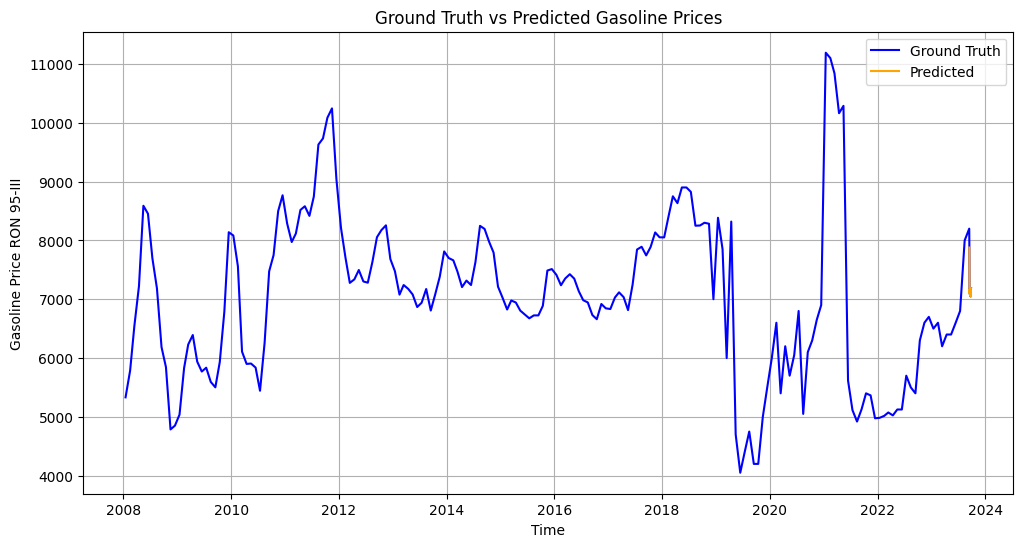

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(df_gasolinePrices_pre.index, df_gasolinePrices_pre['price'], label='Ground Truth', color='blue')
plt.plot(predicted_df_xgb.index, predicted_df_xgb['price'], label='Predicted', color='orange')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

In [23]:
X_train_rf, y_train_rf = X_train, y_train
X_test_rf, y_test_rf = X_test, y_test

In [24]:
# Tạo và huấn luyện mô hình Random Forest
model_rf = RandomForestRegressor(n_estimators=60, max_depth=5)

model_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, n_estimators=60)

In [25]:
y_train_pred_rf = model_rf.predict(X_train_rf)

y_train_pred_rf = scaler.inverse_transform(y_train_pred_rf.reshape(-1, 1))
y_train_rf = scaler.inverse_transform(y_train_rf)

In [26]:
rmse_train_rf = np.sqrt(mean_squared_error(y_train_rf, y_train_pred_rf))
r2_train_rf = r2_score(y_train_rf, y_train_pred_rf)


print("MSE (XGB): ", mean_squared_error(y_train_xgb, y_train_pred_xgb))
print("RMSE (XGB): ", rmse_train_rf)
print("R-squared (XGB): ", r2_train_rf)

MSE (XGB):  20494.16155063036
RMSE (XGB):  191.5701499265978
R-squared (XGB):  0.9732480228004955


In [27]:
y_test_pred_rf = model_rf.predict(X_test_rf)

y_test_pred_rf = scaler.inverse_transform(y_test_pred_rf.reshape(-1, 1))
y_test_rf = scaler.inverse_transform(y_test_rf)

In [28]:
rmse_test_rf = np.sqrt(mean_squared_error(y_test_rf, y_test_pred_rf))
r2_test_rf = r2_score(y_test_rf, y_test_pred_rf)

print("RMSE (XGB): ", rmse_test_rf)
print("R-squared (XGB): ", r2_test_rf)

RMSE (XGB):  318.1575161446401
R-squared (XGB):  0.8453046479893594


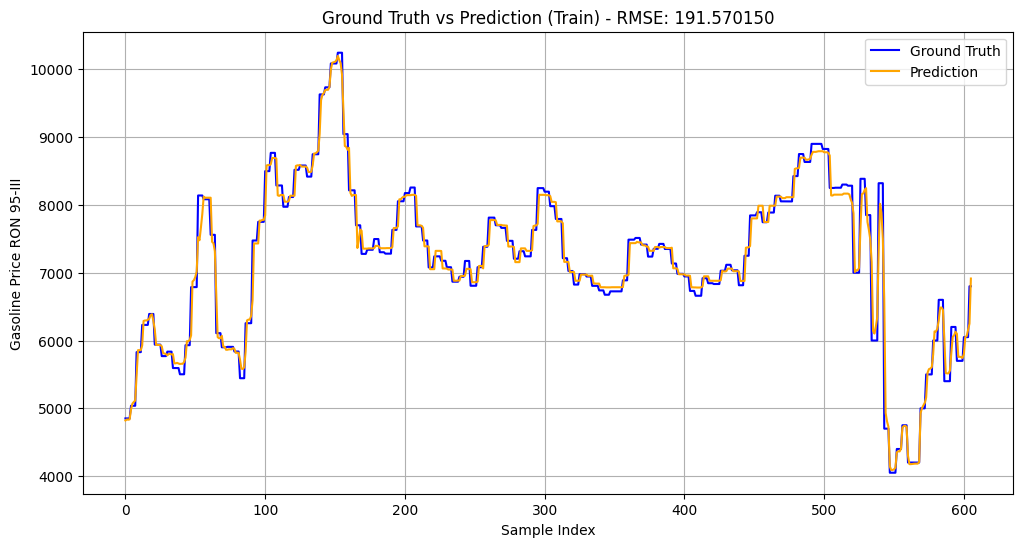

In [29]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth
plt.plot(y_train_rf, label='Ground Truth', color='blue')

# Vẽ đường dự đoán
plt.plot(y_train_pred_rf, label='Prediction', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Ground Truth vs Prediction (Train) - RMSE: {:f}'.format(rmse_train_rf))
plt.xlabel('Sample Index')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

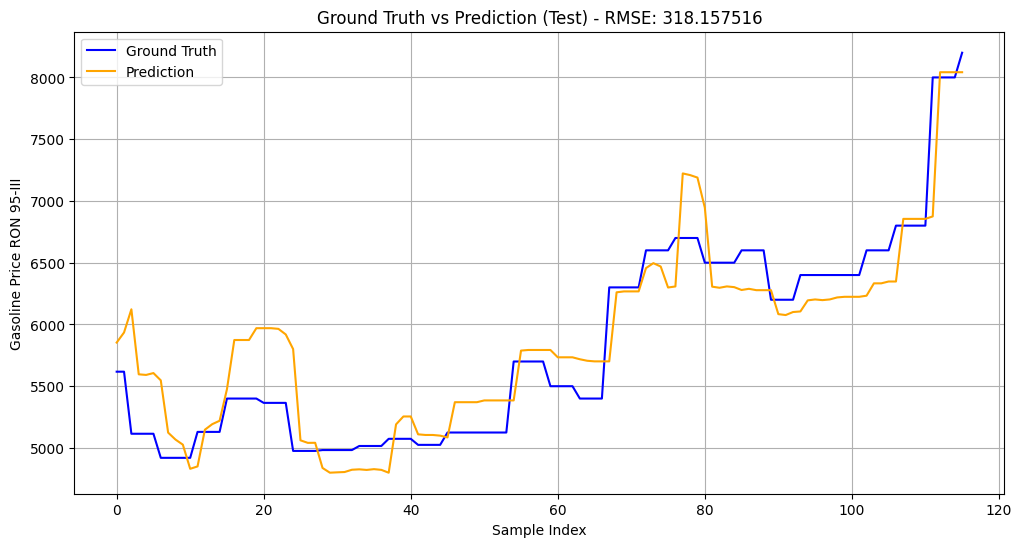

In [30]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth
plt.plot(y_test_rf, label='Ground Truth', color='blue')

# Vẽ đường dự đoán
plt.plot(y_test_pred_rf, label='Prediction', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Ground Truth vs Prediction (Test) - RMSE: {:f}'.format(rmse_test_rf))
plt.xlabel('Sample Index')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

In [31]:
timesteps = 49

In [32]:
days = 12
df_gasolinePrices_pre = df.copy()
gasolinePrices_scaled = scaler.transform(df_gasolinePrices_pre)

# Lấy dữ liệu cuối cùng từ tập dữ liệu
last_data = gasolinePrices_scaled[-timesteps:]
last_data = last_data.reshape(1, -1)[:, -(timesteps-1):]

predicted_prices = []
for day in range(days):
    next_prediction = model_rf.predict(last_data)
    last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
    predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
    predicted_prices.append(predicted_price[0, 0])
    
last_date = df_gasolinePrices_pre.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=days, freq='D')

predicted_df = pd.DataFrame(index=future_dates, columns=['price'])

for day, price in enumerate(predicted_prices, start=1):
    predicted_df.loc[last_date + pd.DateOffset(days=day)] = price

df_gasolinePrices_pre = pd.concat([df_gasolinePrices_pre, predicted_df], axis=0)

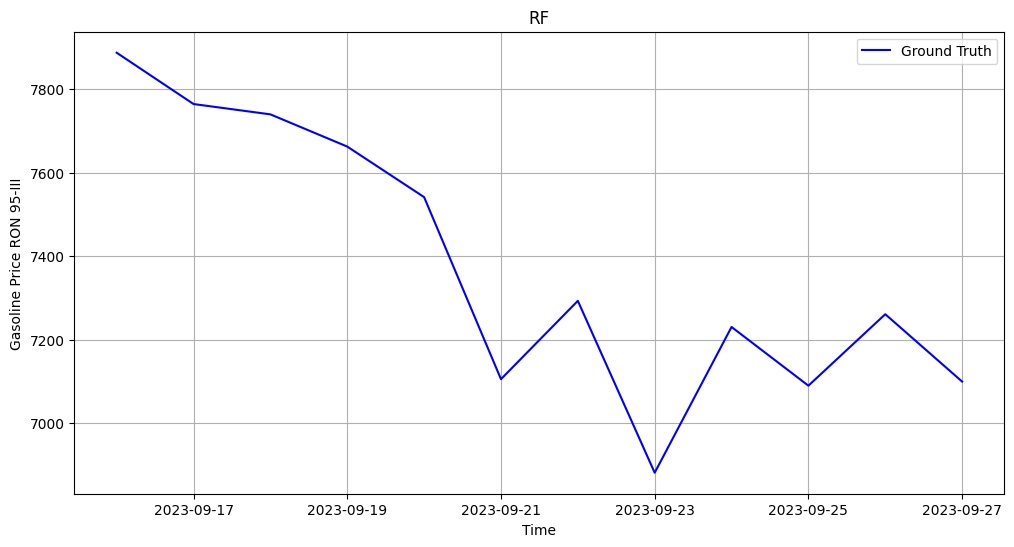

In [33]:
plt.figure(figsize=(12, 6))

plt.plot(predicted_df.index, predicted_df['price'], label='Ground Truth', color='blue')

plt.title('RF')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

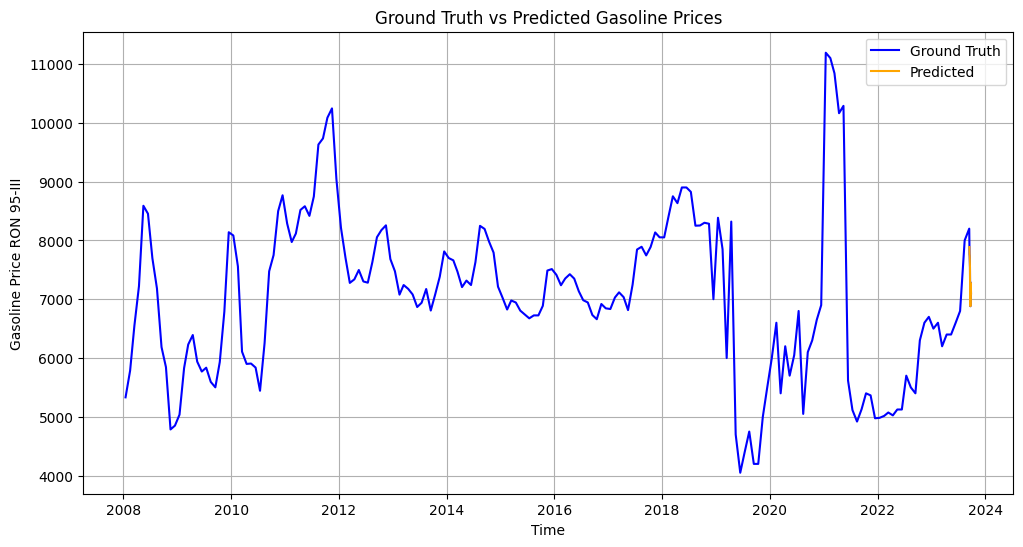

In [34]:
plt.figure(figsize=(12, 6))

plt.plot(df_gasolinePrices_pre.index, df_gasolinePrices_pre['price'], label='Ground Truth', color='blue')
plt.plot(predicted_df.index, predicted_df['price'], label='Predicted', color='orange')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

In [35]:
df_gasolinePrices_pre.shape

(201, 1)

In [36]:
len(df)

189

In [37]:
dt.tail(30)

NameError: name 'dt' is not defined

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
dt = df_gasolinePrices_pre.copy()
fig.add_trace(go.Scatter(x=dt.index, y=dt['price'], marker=dict(
            color=['LightSkyBlue' if x < len(df) else 'Red' for x in range(len(df_gasolinePrices_pre))],
            size=20,
            line=dict(
                color=['LightSkyBlue' if x < len(df) else 'Red' for x in range(len(df_gasolinePrices_pre))],
                width=2
            )
        ), name="Close", mode="lines"))

fig.show()

### SVM

In [ ]:
len(df_gasolinePrices_pre)

201

In [ ]:
['ahcs' if x < len(df) else 'other_color' for x in range(len(df_gasolinePrices_pre))]

['ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 'ahcs',
 

In [ ]:
X_train_svm, y_train_svm = X_train, y_train
X_test_svm, y_test_svm = X_test, y_test

In [ ]:
model_svm = SVR(C=5, kernel='rbf', gamma='auto', epsilon=0.01)

model_svm.fit(X_train_svm, y_train_svm)

SVR(C=5, epsilon=0.01, gamma='auto')

In [ ]:
y_train_pred_svm = model_svm.predict(X_train_svm)
y_train_pred_svm = scaler.inverse_transform(y_train_pred_svm.reshape(-1, 1))
y_train_svm = scaler.inverse_transform(y_train_svm)

In [ ]:
rmse_train_svm = np.sqrt(mean_squared_error(y_train_svm, y_train_pred_svm))
r2_train_svm = r2_score(y_train_svm, y_train_pred_svm)

print("MSE (XGB): ", mean_squared_error(y_train_xgb, y_train_pred_xgb))
print("RMSE (XGB): ", rmse_train_svm)
print("R-squared (XGB): ", r2_train_svm)

RMSE (XGB):  275.31704313196394
R-squared (XGB):  0.9447456593749695


In [ ]:
y_test_pred_svm = model_svm.predict(X_test_svm)
y_test_pred_svm = scaler.inverse_transform(y_test_pred_svm.reshape(-1, 1))
y_test_svm = scaler.inverse_transform(y_test_svm)

In [ ]:
rmse_test_svm = np.sqrt(mean_squared_error(y_test_svm, y_test_pred_svm))
r2_test_svm = r2_score(y_test_svm, y_test_pred_svm)

print("MSE (XGB): ", mean_squared_error(y_train_xgb, y_train_pred_xgb))
print("RMSE (XGB): ", rmse_test_svm)
print("R-squared (XGB): ", r2_test_svm)

RMSE (XGB):  267.0661735431552
R-squared (XGB):  0.8909989558607843


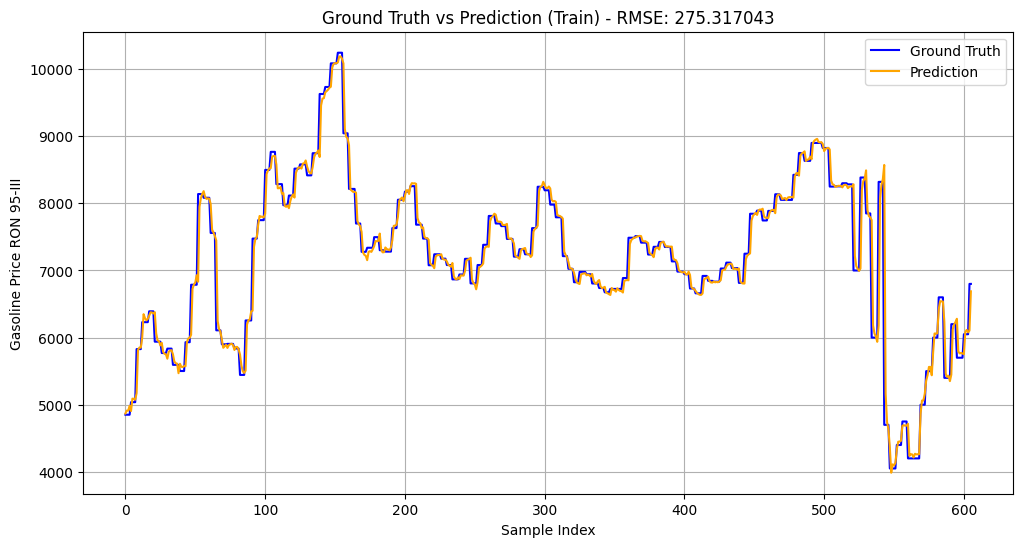

In [ ]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth
plt.plot(y_train_svm, label='Ground Truth', color='blue')

# Vẽ đường dự đoán
plt.plot(y_train_pred_svm, label='Prediction', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Ground Truth vs Prediction (Train) - RMSE: {:f}'.format(rmse_train_svm))
plt.xlabel('Sample Index')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

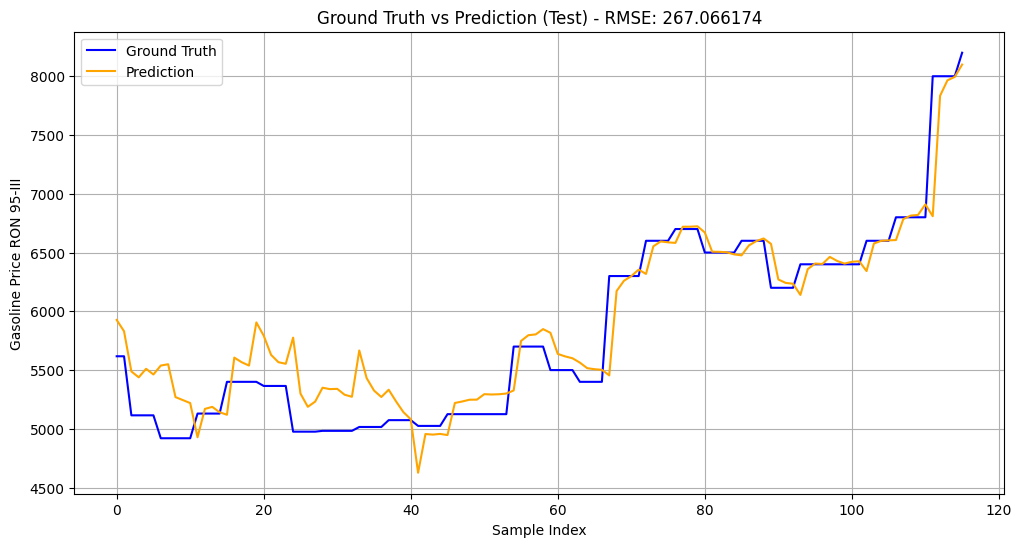

In [ ]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth
plt.plot(y_test_svm, label='Ground Truth', color='blue')

# Vẽ đường dự đoán
plt.plot(y_test_pred_svm, label='Prediction', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Ground Truth vs Prediction (Test) - RMSE: {:f}'.format(rmse_test_svm))
plt.xlabel('Sample Index')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

In [ ]:
days = 12
df_gasolinePrices_pre = df.copy()
gasolinePrices_scaled = scaler.transform(df_gasolinePrices_pre)

# Lấy dữ liệu cuối cùng từ tập dữ liệu
last_data = gasolinePrices_scaled[-timesteps:]
last_data = last_data.reshape(1, -1)[:, -(timesteps-1):]

predicted_prices = []
for day in range(days):
    next_prediction = model_svm.predict(last_data)
    last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
    predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
    predicted_prices.append(predicted_price[0, 0])
    
last_date = df_gasolinePrices_pre.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=days, freq='D')

predicted_df = pd.DataFrame(index=future_dates, columns=['price'])

for day, price in enumerate(predicted_prices, start=1):
    predicted_df.loc[last_date + pd.DateOffset(days=day)] = price

df_gasolinePrices_pre = pd.concat([df_gasolinePrices_pre, predicted_df], axis=0)

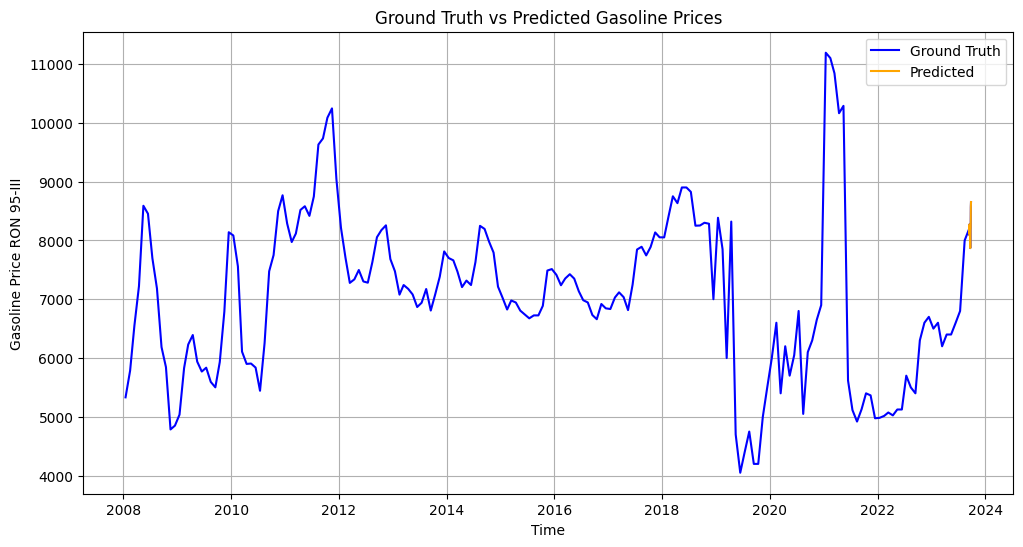

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_gasolinePrices_pre.index, df_gasolinePrices_pre['price'], label='Ground Truth', color='blue')
plt.plot(predicted_df.index, predicted_df['price'], label='Predicted', color='orange')

plt.title('Ground Truth vs Predicted Gasoline Prices')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

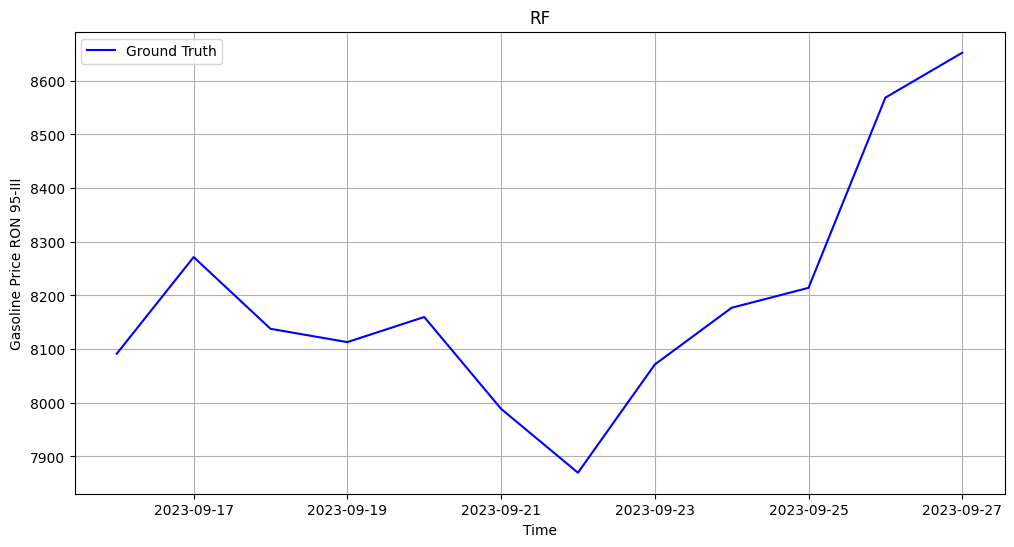

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(predicted_df.index, predicted_df['price'], label='Ground Truth', color='blue')

plt.title('RF')
plt.xlabel('Time')
plt.ylabel('Gasoline Price RON 95-III')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()